In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy

warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
import torchvision.transforms as transforms

In [2]:
device_cuda = torch.device("cuda")
device_cpu = torch.device("cpu")
print(device_cuda, device_cpu)

cuda cpu


In [3]:
project_folder = os.getcwd()
data_folder = os.path.join(project_folder, "Data\\celeba")
img_folder = os.path.join(data_folder, "img_align_celeba") 

In [4]:
data = pd.read_csv(os.path.join(data_folder, 'list_attr_celeba.csv'))
data

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [5]:
df1 = pd.read_csv(os.path.join(data_folder, 'list_attr_celeba.csv'), usecols=['Male','Young'])
df1.loc[df1['Male'] == -1, 'Male'] = 0
df1.loc[df1['Young'] == -1, 'Young'] = 0

df1.head()

,Male,Young
0,0,1
1,0,1
2,1,1
3,0,1
4,0,1


In [6]:
df2 = pd.read_csv(os.path.join(data_folder, 'list_eval_partition.csv'))

df2.columns = ['Filename', 'Partition']
#df2 = df2.set_index('Filename')

df2

,Filename,Partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [7]:
df2

#df1의 인덱스를 기준으로 df1과 df2 병합하기

df = df1.join(df2)
df = df.set_index('Filename')
df

,Male,Young,Partition
Filename,,,
000001.jpg,0,1,0
000002.jpg,0,1,0
000003.jpg,1,1,0
000004.jpg,0,1,0
000005.jpg,0,1,0
...,...,...,...
202595.jpg,0,1,2
202596.jpg,1,1,2
202597.jpg,1,1,2


In [8]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()

,Male,Young,Filename,Partition
0,0,1,000001.jpg,0
1,0,1,000002.jpg,0
2,1,1,000003.jpg,0
3,0,1,000004.jpg,0
4,0,1,000005.jpg,0


In [9]:
df.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Young,Partition
Filename,,,
000001.jpg,0,1,0
000002.jpg,0,1,0
000003.jpg,1,1,0
000004.jpg,0,1,0
000005.jpg,0,1,0


In [13]:
np.random.seed(42)

remove_n = int(len(df4)*0.7)
drop_indices = np.random.choice(df4.index, remove_n, replace=False)
df_subset = df4.drop(drop_indices)
df_subset

,Male,Young,Partition
Filename,,,
000006.jpg,0,1,0
000016.jpg,1,1,0
000027.jpg,0,1,0
000029.jpg,0,1,0
000037.jpg,1,1,0
...,...,...,...
202534.jpg,1,1,2
202544.jpg,0,1,2
202554.jpg,1,1,2


In [19]:
df_subset.loc[df4['Partition'] == 0].to_csv('celeba-old-partitions_train.csv')
df_subset.loc[df4['Partition'] == 1].to_csv('celeba-old-partitions_valid.csv')
df_subset.loc[df4['Partition'] == 2].to_csv('celeba-old-partitions_test.csv')

In [20]:
label_train = pd.read_csv('celeba-old-partitions_train.csv')
label_valid = pd.read_csv('celeba-old-partitions_valid.csv')
label_test = pd.read_csv('celeba-old-partitions_test.csv')

In [47]:
print('Train Young : ' +str(len(label_train.loc[label_train['Young']==1])))
print('Train Old : ' +str(len(label_train.loc[label_train['Young']==0])))
print('Valid Young : ' +str(len(label_valid.loc[label_valid['Young']==1])))
print('Valid Old : ' +str(len(label_valid.loc[label_valid['Young']==0])))
print('Test Young : ' +str(len(label_test.loc[label_test['Young']==1])))
print('Test Old : ' +str(len(label_test.loc[label_test['Young']==0])))

Train Young : 12714
Train Old : 3688
Valid Young : 1459
Valid Old : 478
Test Young : 1451
Test Old : 470


In [21]:
print('Young Male : '+ str(len(label_train.loc[(label_train['Male'] == 1) & (label_train['Young']==1)])))
print('Old Male : '+ str(len(label_train.loc[(label_train['Male'] == 1) & (label_train['Young']==0)])))
print('Young Female : '+ str(len(label_train.loc[(label_train['Male'] == 0) & (label_train['Young']==1)])))
print('Old Female : '+ str(len(label_train.loc[(label_train['Male'] == 0) & (label_train['Young']==0)])))


Young Male : 4349
Old Male : 2558
Young Female : 8365
Old Female : 1130


In [57]:
label_train.describe()

,Male,Young,Partition
count,16297.000000,16297.000000,16297.0
mean,0.417071,0.776891,0.0
std,0.493090,0.416343,0.0
min,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.0
50%,0.000000,1.000000,0.0
75%,1.000000,1.000000,0.0
max,1.000000,1.000000,0.0


In [58]:
label_test.describe()

,Male,Young,Partition
count,1994.000000,1994.000000,1994.0
mean,0.385657,0.760281,2.0
std,0.486872,0.427019,0.0
min,0.000000,0.000000,2.0
25%,0.000000,1.000000,2.0
50%,0.000000,1.000000,2.0
75%,1.000000,1.000000,2.0
max,1.000000,1.000000,2.0


In [54]:
label_train.loc[label_train['Young']==0]

,Filename,Male,Young,Partition
7,000051.jpg,1,0,0
12,000067.jpg,1,0,0
15,000127.jpg,1,0,0
18,000156.jpg,0,0,0
23,000193.jpg,1,0,0
...,...,...,...,...
16392,162697.jpg,1,0,0
16394,162718.jpg,0,0,0
16395,162728.jpg,1,0,0
16398,162736.jpg,0,0,0


In [97]:
AUGMENTATION = False

if AUGMENTATION == True:
    
    transform_aug = transforms.Compose(
                    [transforms.RandomHorizontalFlip(p = 0.5),
                     transforms.RandomAffine(degrees = 360)])
                    #transforms.RandomRotation(degrees = 30),

    output_folder = os.path.join(data_folder, "aug_old")
    aug_train = copy.deepcopy(label_train)    

    for file in label_train.loc[label_train['Young']==0]['Filename']:
        image = Image.open(os.path.join(img_folder, file))
        image.save(os.path.join(output_folder,file))
        new = copy.deepcopy(label_train.loc[label_train['Filename']==file])
        
        file2 = file[:-4]+'_2.jpg'
        new['Filename'] = file2
        aug_train = aug_train.append(new, ignore_index=True)
        
        aug_img1 = transform_aug(image)
        aug_img1.save(os.path.join(output_folder,file2))
        
        file3 = file[:-4]+'_3.jpg'
        new['Filename'] = file3
        aug_train = aug_train.append(new, ignore_index=True)
        
        aug_img2 = transform_aug(image)
        aug_img2.save(os.path.join(output_folder,file3))
        
    for file in label_train.loc[label_train['Young']==1]['Filename']:
        image = Image.open(os.path.join(img_folder, file))
        image.save(os.path.join(output_folder,file))

In [120]:
aug_train.set_index('Filename').to_csv('celeba-old-augmentations_train.csv')

In [ ]:
Image.open(aug_)

In [123]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.att = df['Young'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        attribute = self.att[index]
        return img, label, attribute

    def __len__(self):
        return self.y.shape[0]
    

In [130]:
Resnet18 = copy.deepcopy(models.resnet18(pretrained = True))
Resnet18.fc = nn.Linear(512, 1)
Resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [243]:
def Train(model, optimizer, loss_fn, n_epochs, scheduler = None, OVER = False):
    
    torch.cuda.empty_cache()    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_loss = 10 ** 3
    patience_limit = 10
    patience_check = 0   
    
    for epoch in range(n_epochs):
        running_loss = 0
        running_acc = 0
        
        model.train()
        if OVER == True:
            loader = aug_train_loader
            dataset = aug_train_dataset
        else:
            loader = train_loader
            dataset = train_dataset
        
        for x, y_t, att in loader:
            x, y_t, att = x.to(device_cuda), y_t.to(device_cuda, dtype=torch.float32), att.to(device_cuda, dtype=torch.float32)
            output = torch.sigmoid(model(x).flatten())
            
            ones_like_y = torch.ones_like(output, dtype = torch.int).to(device_cuda)
            zeros_like_y = torch.zeros_like(output, dtype = torch.int).to(device_cuda)
            y_pred = torch.where(output >= ones_like_y * 0.5, ones_like_y, zeros_like_y)
            
            criterion = loss_fn
            loss = criterion(output, y_t)
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
                        
            running_loss += loss.item()
            running_acc += torch.sum(y_pred == y_t)
            
            del x
            torch.cuda.empty_cache()
            
        if scheduler is not None:
            scheduler.step()
        
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for x, y_t, att in valid_loader:
                x, y_t, att = x.to(device_cuda), y_t.to(device_cuda, dtype=torch.float32), att.to(device_cuda, dtype=torch.float32)
                
                output = torch.sigmoid(model(x).flatten())
                
                ones_like_y = torch.ones_like(output, dtype = torch.int).to(device_cuda)
                zeros_like_y = torch.zeros_like(output, dtype = torch.int).to(device_cuda)
                y_pred = torch.where(output >= ones_like_y * 0.5, ones_like_y, zeros_like_y)
                
                # evaluation metrics
                criterion = loss_fn
                loss = criterion(output, y_t)         
            
                val_loss += loss.item()
                val_acc += torch.sum(y_pred == y_t)
                
                del x
                torch.cuda.empty_cache()
                                
            if val_loss > best_loss:
                patience_check += 1
                print(patience_check)
                
            else: # loss가 개선된 경우
                best_loss = val_loss
                patience_check = 0
                best_model, best_epoch = copy.deepcopy(model), epoch

            if patience_check >= patience_limit: # early stopping
                print('Early stopped')
                break

        # calculate mean for each batch
        train_losses.append(running_loss / len(loader))
        train_accs.append(running_acc / len(dataset))
        val_losses.append(val_loss / len(valid_loader))
        val_accs.append(val_acc / len(valid_dataset))

        
        print(' ')
        print("Epoch:{}/{}..".format(epoch + 1, n_epochs),
                "Train Loss: {:.4f}..".format(running_loss / len(loader)),
                "Train Acc: {:.4f}..".format(running_acc / len(dataset)),
                "Val Loss: {:.4f}..".format(val_loss / len(valid_loader)),
                "Val Acc: {:.4f}..".format(val_acc / len(valid_dataset)),
             )

    history = {'train_loss': train_losses, 'train_acc': train_accs,
               'val_loss': val_losses, 'val_acc': val_accs}
    
    save_name = os.path.join(model_save_folder, model_name)
    torch.save(best_model.state_dict(), save_name)
    
    model = best_model
    
    return history


In [132]:
#cc
def Test(model, loss_fn):
    
    criterion = loss_fn
    # enter evaluation mode
    model.eval()
    test_loss = 0
    with torch.no_grad():
        
        pred = []
        t = []
        for x, y_t, att in test_loader:
            x, y_t, att = x.to(device_cuda), y_t.to(device_cuda, dtype=torch.float32), att.to(device_cuda, dtype=torch.float32)

            output = torch.sigmoid(model(x).flatten())
            test_loss += criterion(output, y_t) # sum up batch loss

            ones_like_y = torch.ones_like(output, dtype = torch.int).to(device_cuda)
            zeros_like_y = torch.zeros_like(output, dtype = torch.int).to(device_cuda)

            y_pred = torch.where(output >= ones_like_y * 0.5, ones_like_y, zeros_like_y)
            pred.extend(y_pred.cpu().numpy())
            t.extend(y_t.cpu().numpy())
        
        cf_matrix = confusion_matrix(t, pred)

        TN = cf_matrix[0,0]
        FP = cf_matrix[0,1]
        FN = cf_matrix[1,0]
        TP = cf_matrix[1,1]

        Acc = (TP + TN) / (TP + TN + FP + FN)
        PPV = TP / (TP + FP)
        NPV = TN / (TN + FN)
        Sens = TP / (TP + FN)
        F1 = (2 * PPV * Sens) / (PPV + Sens)
        Spec = TN / (TN + FP)

        test_loss /= len(test_loader)
        print('(Accuracy, PPV, NPV, Sensitivity, Specificity, F1, Loss) = %.3f, %.3f, %.3f, %.3f, %.3f, %.3f, %.3f' 
                          %(Acc, PPV, NPV, Sens, Spec, F1, test_loss))

        return Acc, Sens, Spec, PPV, NPV, F1


In [245]:
BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.CenterCrop((178, 178)),
                                transforms.Resize((224,224))
                               ])

train_dataset = CelebaDataset(csv_path='celeba-old-partitions_train.csv', # male
                              img_dir=img_folder,
                              transform=transform)

valid_dataset = CelebaDataset(csv_path='celeba-old-partitions_valid.csv',
                              img_dir=img_folder,
                              transform=transform)

test_dataset = CelebaDataset(csv_path='celeba-old-partitions_test.csv',
                             img_dir=img_folder,
                             transform=transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

# AUGMENTATION

aug_folder = os.path.join(data_folder, "aug_old")
aug_train_dataset = CelebaDataset(csv_path='celeba-old-augmentations_train.csv', # male
                              img_dir=aug_folder,
                              transform=transform)

aug_train_loader = DataLoader(dataset=aug_train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

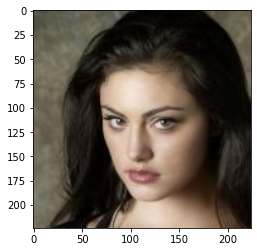

(0, 1)


In [246]:
img = train_dataset.__getitem__(917)[0]
tf = transforms.ToPILImage()
img = tf(img)
plt.imshow(img)
plt.show()

print(train_dataset.__getitem__(917)[1:])

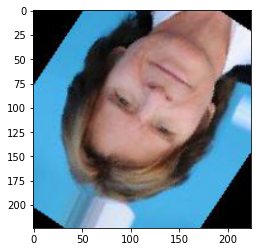

(1, 0)


In [247]:
img = aug_train_dataset.__getitem__(17800)[0]
tf = transforms.ToPILImage()
img = tf(img)
plt.imshow(img)
plt.show()

print(aug_train_dataset.__getitem__(17800)[1:])

In [249]:
# dataset 개수 확인

print('Training set: {}'.format(len(train_dataset)))
print('Validation set: {}'.format(len(valid_dataset)))
print('Test set: {}'.format(len(test_dataset)))
print('Over_Training set: {}'.format(len(AUG_train_dataset)))

Training set: 16402
Validation set: 1937
Test set: 1921
Over_Training set: 23778


In [250]:
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
CRITERION = nn.BCELoss()
N_EPOCHS = 30

In [251]:
model_save_folder = os.path.join(project_folder, "model_save")
model_name = 'Gender_Young_original.pt'

model = copy.deepcopy(Resnet18).to(device_cuda)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)
Train(model, optimizer, loss_fn = CRITERION , n_epochs = N_EPOCHS, scheduler = None)

 
Epoch:1/30.. Train Loss: 0.7157.. Train Acc: 0.5725.. Val Loss: 0.7883.. Val Acc: 0.5075..
 
Epoch:2/30.. Train Loss: 0.4120.. Train Acc: 0.7983.. Val Loss: 0.3774.. Val Acc: 0.8601..
 
Epoch:3/30.. Train Loss: 0.2308.. Train Acc: 0.9054.. Val Loss: 0.2326.. Val Acc: 0.9189..
1
 
Epoch:4/30.. Train Loss: 0.2118.. Train Acc: 0.9148.. Val Loss: 0.6931.. Val Acc: 0.6649..
2
 
Epoch:5/30.. Train Loss: 0.1887.. Train Acc: 0.9254.. Val Loss: 0.4402.. Val Acc: 0.7594..
3
 
Epoch:6/30.. Train Loss: 0.1817.. Train Acc: 0.9254.. Val Loss: 0.2605.. Val Acc: 0.9308..
4
 
Epoch:7/30.. Train Loss: 0.1719.. Train Acc: 0.9311.. Val Loss: 0.2834.. Val Acc: 0.8776..
 
Epoch:8/30.. Train Loss: 0.1634.. Train Acc: 0.9335.. Val Loss: 0.1948.. Val Acc: 0.9344..
1
 
Epoch:9/30.. Train Loss: 0.1504.. Train Acc: 0.9405.. Val Loss: 0.4252.. Val Acc: 0.8286..
2
 
Epoch:10/30.. Train Loss: 0.1505.. Train Acc: 0.9396.. Val Loss: 0.2228.. Val Acc: 0.9122..
3
 
Epoch:11/30.. Train Loss: 0.1517.. Train Acc: 0.9384.

{'train_loss': [0.7157348944235218,
  0.4119520204704861,
  0.23078389991392462,
  0.21175527988478196,
  0.1886732272746027,
  0.18173510904691015,
  0.1719165700235108,
  0.1634293241325275,
  0.1504074920170991,
  0.15051735221415527,
  0.1516775252340838,
  0.14120501152766768,
  0.14177480091651282,
  0.13652040145193883,
  0.12960771095845125,
  0.1292723954994549,
  0.13177187619514244,
  0.12964496547861618,
  0.12602007048305616,
  0.12903737747507502,
  0.12043370491312455,
  0.1206043111088202,
  0.12508464344712192,
  0.11641809292310892,
  0.1152967069038125,
  0.1179457962108675,
  0.11632958461725434],
 'train_acc': [tensor(0.5725, device='cuda:0'),
  tensor(0.7983, device='cuda:0'),
  tensor(0.9054, device='cuda:0'),
  tensor(0.9148, device='cuda:0'),
  tensor(0.9254, device='cuda:0'),
  tensor(0.9254, device='cuda:0'),
  tensor(0.9311, device='cuda:0'),
  tensor(0.9335, device='cuda:0'),
  tensor(0.9405, device='cuda:0'),
  tensor(0.9396, device='cuda:0'),
  tensor(0.9

In [260]:
model = copy.deepcopy(Resnet18).to(device_cuda)
model_save_folder = os.path.join(project_folder, "model_save")
model_name = 'Gender_Young_original.pt'
load_name = os.path.join(model_save_folder, model_name)
model.load_state_dict(torch.load(load_name))

Test(model, loss_fn = CRITERION)

(Accuracy, PPV, NPV, Sensitivity, Specificity, F1, Loss) = 0.943, 0.903, 0.971, 0.956, 0.934, 0.928, 0.148


(0.9427381572097866,
 0.9558232931726908,
 0.934412265758092,
 0.9026548672566371,
 0.9707964601769912,
 0.9284785435630689)

In [253]:
#Aug
model_save_fdolder = os.path.join(project_folder, "model_save")
model_name = 'Gender_Young_over.pt'

model = copy.deepcopy(Resnet18).to(device_cuda)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)
Train(model, optimizer, loss_fn = CRITERION , n_epochs = N_EPOCHS, scheduler = None, OVER = True)

 
Epoch:1/30.. Train Loss: 0.7765.. Train Acc: 0.5495.. Val Loss: 1.1977.. Val Acc: 0.4239..
 
Epoch:2/30.. Train Loss: 0.4648.. Train Acc: 0.7784.. Val Loss: 0.3445.. Val Acc: 0.8585..
 
Epoch:3/30.. Train Loss: 0.3306.. Train Acc: 0.8520.. Val Loss: 0.2285.. Val Acc: 0.9143..
1
 
Epoch:4/30.. Train Loss: 0.2895.. Train Acc: 0.8739.. Val Loss: 0.5421.. Val Acc: 0.7326..
 
Epoch:5/30.. Train Loss: 0.2752.. Train Acc: 0.8846.. Val Loss: 0.1903.. Val Acc: 0.9370..
1
 
Epoch:6/30.. Train Loss: 0.2635.. Train Acc: 0.8904.. Val Loss: 0.2098.. Val Acc: 0.9319..
2
 
Epoch:7/30.. Train Loss: 0.2589.. Train Acc: 0.8944.. Val Loss: 0.3343.. Val Acc: 0.8554..
3
 
Epoch:8/30.. Train Loss: 0.2432.. Train Acc: 0.8985.. Val Loss: 0.3152.. Val Acc: 0.8704..
 
Epoch:9/30.. Train Loss: 0.2414.. Train Acc: 0.9027.. Val Loss: 0.1880.. Val Acc: 0.9350..
1
 
Epoch:10/30.. Train Loss: 0.2275.. Train Acc: 0.9093.. Val Loss: 0.2036.. Val Acc: 0.9231..
2
 
Epoch:11/30.. Train Loss: 0.2237.. Train Acc: 0.9101.. 

{'train_loss': [0.7764799123810183,
  0.46481839174865397,
  0.3306074824224236,
  0.2895026513004816,
  0.27523774012763014,
  0.26349550693906765,
  0.2588873393433068,
  0.24321482426697208,
  0.24143668536537438,
  0.22752611102756634,
  0.22369780719921153,
  0.22456146384118705,
  0.213378543174395,
  0.2080963635717028,
  0.20660282098638114,
  0.20826915859855633,
  0.19958861396517805,
  0.19926700384546353,
  0.19575830965593297,
  0.1960318435023549,
  0.18723920508418032,
  0.18885860483973257],
 'train_acc': [tensor(0.5495, device='cuda:0'),
  tensor(0.7784, device='cuda:0'),
  tensor(0.8520, device='cuda:0'),
  tensor(0.8739, device='cuda:0'),
  tensor(0.8846, device='cuda:0'),
  tensor(0.8904, device='cuda:0'),
  tensor(0.8944, device='cuda:0'),
  tensor(0.8985, device='cuda:0'),
  tensor(0.9027, device='cuda:0'),
  tensor(0.9093, device='cuda:0'),
  tensor(0.9101, device='cuda:0'),
  tensor(0.9108, device='cuda:0'),
  tensor(0.9161, device='cuda:0'),
  tensor(0.9141, de

In [255]:
model = copy.deepcopy(Resnet18).to(device_cuda)
model_save_folder = os.path.join(project_folder, "model_save")
model_name = 'Gender_Young_over.pt'
load_name = os.path.join(model_save_folder, model_name)
model.load_state_dict(torch.load(load_name))


Test(model, loss_fn = CRITERION)

(Accuracy, PPV, NPV, Sensitivity, Specificity, F1, Loss) = 0.928, 0.912, 0.938, 0.902, 0.945, 0.907, 0.159


(0.9281624154086413,
 0.9022757697456493,
 0.944633730834753,
 0.912043301759134,
 0.9382402707275804,
 0.9071332436069987)

<BarContainer object of 4 artists>

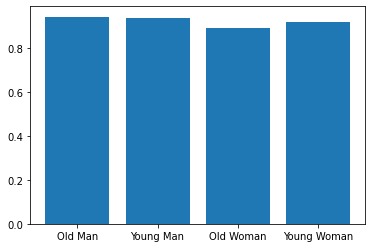

In [256]:
model = copy.deepcopy(Resnet18).to(device_cuda)
model_save_folder = os.path.join(project_folder, "model_save")
model_name = 'Gender_Young_original.pt'
load_name = os.path.join(model_save_folder, model_name)
model.load_state_dict(torch.load(load_name))

model.eval()
with torch.no_grad():

    pred_old_man = []
    pred_young_man = []
    pred_old_woman = []
    pred_young_woman = []
    
    for x, y_t, att in test_loader:
        x, y_t, att = x.to(device_cuda), y_t.to(device_cuda, dtype=torch.float32), att.to(device_cuda, dtype=torch.float32)

        output = torch.sigmoid(model(x).flatten())
                
        y_pred_om = torch.where(output[y_t == 1][att[y_t == 1]==0] >= 0.5, 1, 0)
        y_pred_ym = torch.where(output[y_t == 1][att[y_t == 1]==1] >= 0.5, 1, 0)
        y_pred_ow = torch.where(output[y_t == 0][att[y_t == 0]==0] >= 0.5, 1, 0)
        y_pred_yw = torch.where(output[y_t == 0][att[y_t == 0]==1] >= 0.5, 1, 0)

        pred_old_man.extend(y_pred_om.cpu().numpy())
        pred_young_man.extend(y_pred_ym.cpu().numpy())
        pred_old_woman.extend(y_pred_ow.cpu().numpy())
        pred_young_woman.extend(y_pred_yw.cpu().numpy())
        
acc_om = np.sum(np.array(pred_old_man)==1)/len(pred_old_man) * 100
acc_ym =np.sum(np.array(pred_young_man)==1)/len(pred_young_man) * 100
acc_ow =np.sum(np.array(pred_old_woman)==0)/len(pred_old_woman) * 100
acc_yw =np.sum(np.array(pred_young_woman)==0)/len(pred_young_woman) * 100

index = ['Old Man', 'Young Man', 'Old Woman', 'Young Woman']
accs_original = [acc_om, acc_ym, acc_ow, acc_yw]

plt.bar(index, accs)

<BarContainer object of 4 artists>

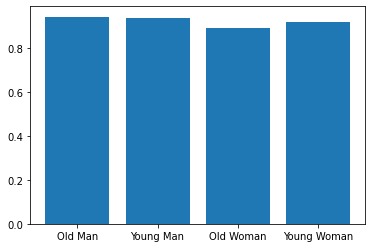

In [257]:
model = copy.deepcopy(Resnet18).to(device_cuda)
model_save_folder = os.path.join(project_folder, "model_save")
model_name = 'Gender_Young_over.pt'
load_name = os.path.join(model_save_folder, model_name)
model.load_state_dict(torch.load(load_name))

model.eval()
with torch.no_grad():

    pred_old_man = []
    pred_young_man = []
    pred_old_woman = []
    pred_young_woman = []
    
    for x, y_t, att in test_loader:
        x, y_t, att = x.to(device_cuda), y_t.to(device_cuda, dtype=torch.float32), att.to(device_cuda, dtype=torch.float32)

        output = torch.sigmoid(model(x).flatten())
                
        y_pred_om = torch.where(output[y_t == 1][att[y_t == 1]==0] >= 0.5, 1, 0)
        y_pred_ym = torch.where(output[y_t == 1][att[y_t == 1]==1] >= 0.5, 1, 0)
        y_pred_ow = torch.where(output[y_t == 0][att[y_t == 0]==0] >= 0.5, 1, 0)
        y_pred_yw = torch.where(output[y_t == 0][att[y_t == 0]==1] >= 0.5, 1, 0)

        pred_old_man.extend(y_pred_om.cpu().numpy())
        pred_young_man.extend(y_pred_ym.cpu().numpy())
        pred_old_woman.extend(y_pred_ow.cpu().numpy())
        pred_young_woman.extend(y_pred_yw.cpu().numpy())
        
acc_om = np.sum(np.array(pred_old_man)==1)/len(pred_old_man)  * 100
acc_ym =np.sum(np.array(pred_young_man)==1)/len(pred_young_man) * 100
acc_ow =np.sum(np.array(pred_old_woman)==0)/len(pred_old_woman) * 100
acc_yw =np.sum(np.array(pred_young_woman)==0)/len(pred_young_woman) * 100

index = ['Old Man', 'Young Man', 'Old Woman', 'Young Woman']
accs_over = [acc_om, acc_ym, acc_ow, acc_yw]

plt.bar(index, accs)

In [144]:
#del model
#torch.cuda.empty_cache()

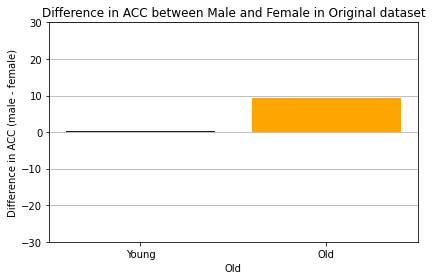

In [261]:
# ACC(male)과 ACC(female)의 차이 계산
diff_biased =  [accs_original[1] - accs_original[3], accs_original[0] - accs_original[2]]

# 데이터 시각화
categories = ['Young', 'Old']
#diffs = [diff_oversampled, diff_biased]

plt.figure(figsize=(6, 4))
plt.ylim(-30,30)
plt.bar(categories, diff_biased, color=['blue', 'orange'])
plt.xlabel('Old')
plt.ylabel('Difference in ACC (male - female)')
plt.title('Difference in ACC between Male and Female in Original dataset')
plt.grid(axis='y')
plt.tight_layout()

plt.show()

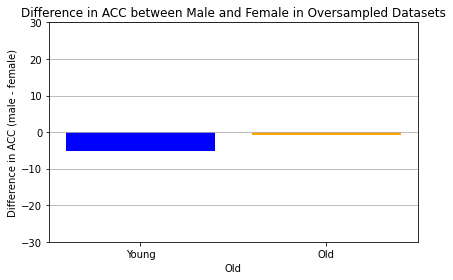

In [262]:

# ACC(male)과 ACC(female)의 차이 계산
diff_oversampled = [accs_over[1] - accs_over[3], accs_over[0] - accs_over[2]]
# 데이터 시각화
categories = ['Young', 'Old']
#diffs = [diff_oversampled, diff_biased]

plt.figure(figsize=(6, 4))
plt.ylim(-30,30)
plt.bar(categories, diff_oversampled, color=['blue', 'orange'])
plt.xlabel('Old')
plt.ylabel('Difference in ACC (male - female)')
plt.title('Difference in ACC between Male and Female in Oversampled Datasets')
plt.grid(axis='y')
plt.tight_layout()

plt.show()